# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

                                                                                               - Rajagopal Shenoy
                                                                                               - Anindya Sudhir

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action | Class Label |
| --- | --- | --- |
| Left Swipe | Jump backwards 10 seconds | 0 |
| Right Swipe | Jump forward 10 seconds | 1 |
| Stop | Pause the movie | 2 |
| Thumbs Up | Increase the volume | 3 |
| Thumbs Down | Decrease the volume | 4 |


Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [2]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import os
import imageio #from scipy.misc import imread, imresize is deprecated
import datetime
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)  # Use this if tensorflow version is 1.10.0
#tf.random.set_seed(30) # Use this if tensorflow version is newer than 1.10.0

In [3]:
# Tensorflow version in Nimblebox GPU setup
tf.__version__

'1.10.0'

In [5]:
# Import all the required Keras modules
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Input
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from keras.applications import VGG16
from keras.applications import ResNet50

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines()) # To be used as folder_list in generator function
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
# More details on batch size is given later in the code
batch_size = 50 #experiment with the batch size 

train_path = './Project_data/train' # To be used as source_path in generator function
val_path = './Project_data/val'

## EDA - Analysis of the Images to see the size and augmentation requirements

- All the images present in the folder are of size either 120x160x3 or 360x360x3. So they have to be brought to same size i.e. bring them to size 120x120x3
- Also, see if all 30 images are needed. May be first few and last few can be removed (as the movement gets captured by middle frames)
- See if any type of Image Augmentation is necessary

In [7]:
# Create a seperate data frame of train data for EDA
train_df = pd.read_csv('./Project_data/train.csv',header = None)
train_df = train_df[0].str.split(pat = ';',expand = True)
train_df.rename(columns = {0: 'name', 1: 'gesture', 2: 'class'},inplace = True)
train_df.head()

,name,gesture,class
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [8]:
# Check for class imbalance
train_df['class'].value_counts()

3    137
1    137
0    136
2    130
4    123
Name: class, dtype: int64

One can see good fair distribution of videos for every class. So all five classes are well balanced

In [9]:
# Let us see images are of which shape. It will help us in reshaping all of them to the same size
shape1 = 0
shape2 = 0
shape3 = 0

for folder in train_df['name']:
    temp = os.listdir('./Project_data/train'+'/'+ folder)
    if(imageio.imread('./Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (120,160,3)):
        shape1 += 1
    elif(imageio.imread('./Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (360,360,3)):
        shape2 += 1
    else:
        shape3 += 1
         
print('Number of images with shape 120x160x3:', shape1)
print('Number of images with shape 360x360x3:', shape2)
print('Number of images with other shapes   :', shape3)

Number of images with shape 120x160x3: 479
Number of images with shape 360x360x3: 184
Number of images with other shapes   : 0


- As one can see images are either of 120x160x3 or 360x360x3 shape
- They shall be reshaped to 120x120x3 later in the code

- Now, let us look at the images along with some augmentations like edge detection, normalization and blurring

In [10]:
# Let us write a custom function to show the images and their augmentation
def imageview(class_img, source_path):
    
    # Get all 30 images in the folder
    images = os.listdir(source_path+'/'+ class_img)
    # Select one image (I have chosen 15th image) among the 30 images
    image = imageio.imread(source_path+'/'+ class_img +'/'+images[14])
    print('original:',image.shape)
    
    # Resize the image
    resized_img = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
    print('resized:',resized_img.shape)
    
    # Apply Gaussian Blur on the image
    blur_image = cv2.GaussianBlur(resized_img, (3,3), 3)
    print('blurred:',blur_image.shape)
    
    # Image Edge Detection
    edge_image = cv2.Canny(blur_image, 75, 150)
    # Get it into shape of 120x120x3 to maintain same shape through out (Canny removes the channels)
    edge_image1 = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2BGR)
    print('edge:',edge_image1.shape)
    
    # Normalize the image
    norm_img = resized_img/255
    print('normalized:',norm_img.shape)
    
    fig = plt.figure(figsize = (20, 30))
    
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image)
    
    plt.subplot(152)
    plt.title('Resized')
    plt.imshow(resized_img) 
     
    plt.subplot(153)
    plt.title('Gaussian Blur')
    plt.imshow(blur_image)
    
    plt.subplot(154)
    plt.title('Edges')
    plt.imshow(edge_image1, cmap = 'gray')
    
    plt.subplot(155)
    plt.title('Normalized')
    plt.imshow(norm_img)

    plt.show()

In [11]:
# Consider two images (one with 120x160x3 and another with 360x360x3) each from every class for analysis
class_0_120 = train_df[train_df['class']=='0'].reset_index()['name'][1]
class_0_360 = train_df[train_df['class']=='0'].reset_index()['name'][134]
class_1_120 = train_df[train_df['class']=='1'].reset_index()['name'][0]
class_1_360 = train_df[train_df['class']=='1'].reset_index()['name'][133]
class_2_120 = train_df[train_df['class']=='2'].reset_index()['name'][2]
class_2_360 = train_df[train_df['class']=='2'].reset_index()['name'][120]
class_3_120 = train_df[train_df['class']=='3'].reset_index()['name'][3]
class_3_360 = train_df[train_df['class']=='3'].reset_index()['name'][131]
class_4_120 = train_df[train_df['class']=='4'].reset_index()['name'][4]
class_4_360 = train_df[train_df['class']=='4'].reset_index()['name'][110]

Image for Swipe Left:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


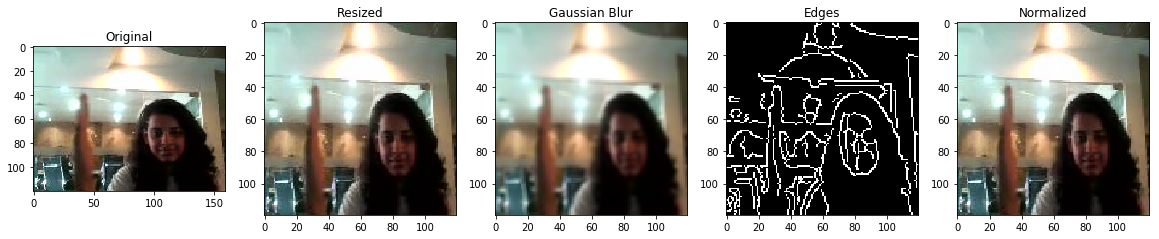

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


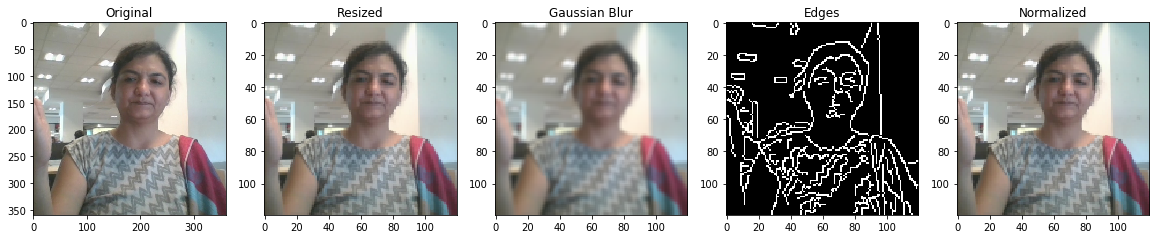

Image for Swipe Right:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


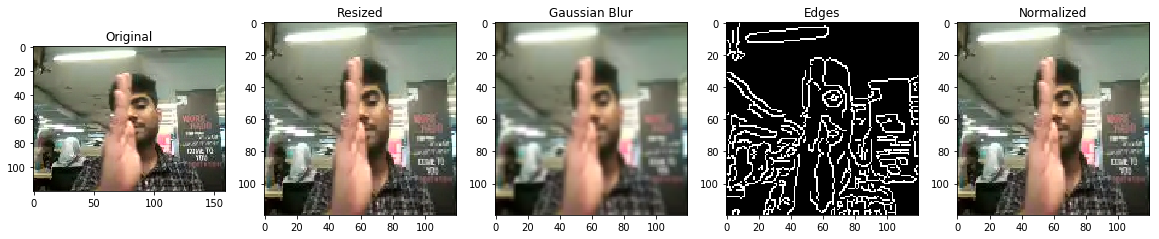

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


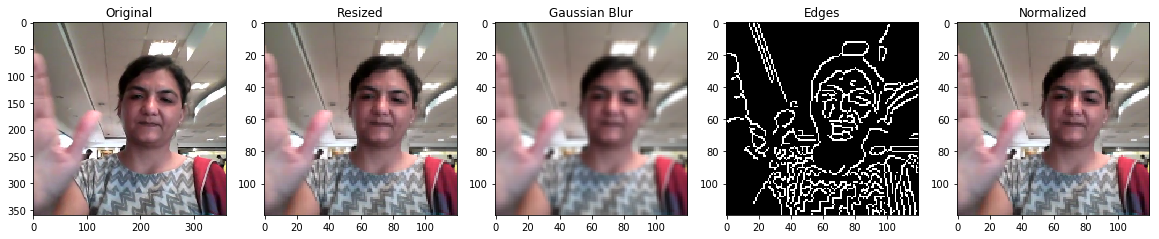

Image for Stop:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


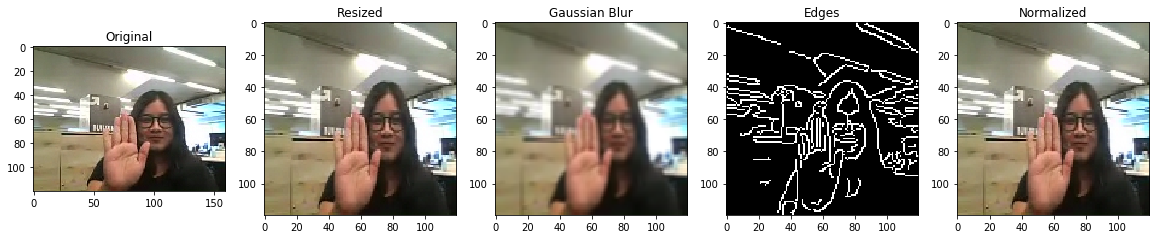

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


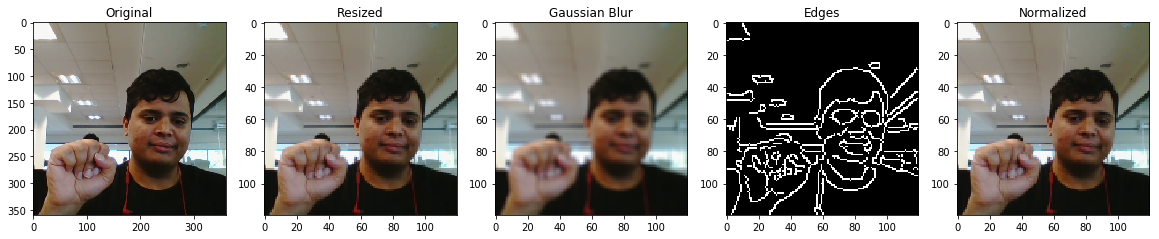

Image for Volume Down:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


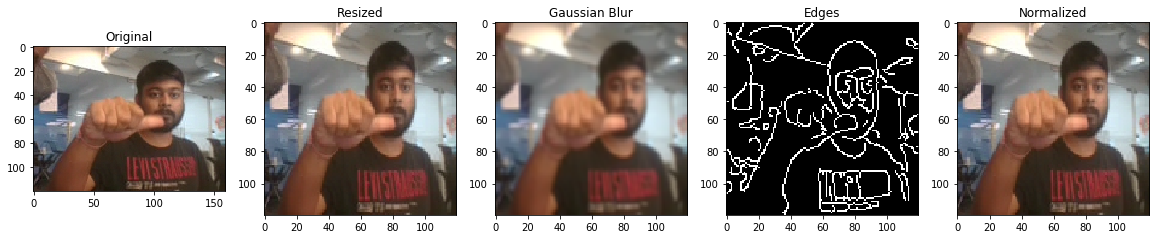

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


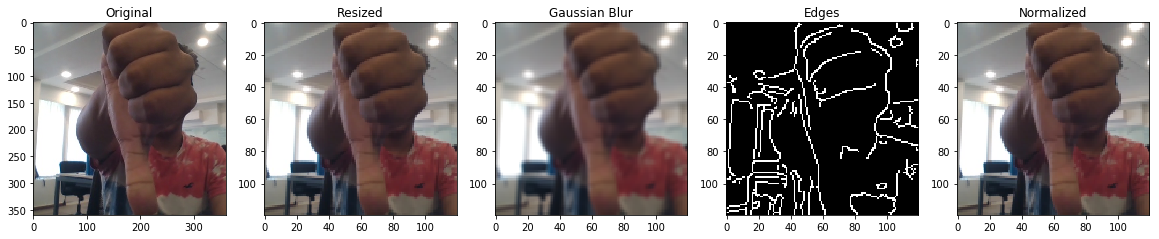

Image for Volume Up:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


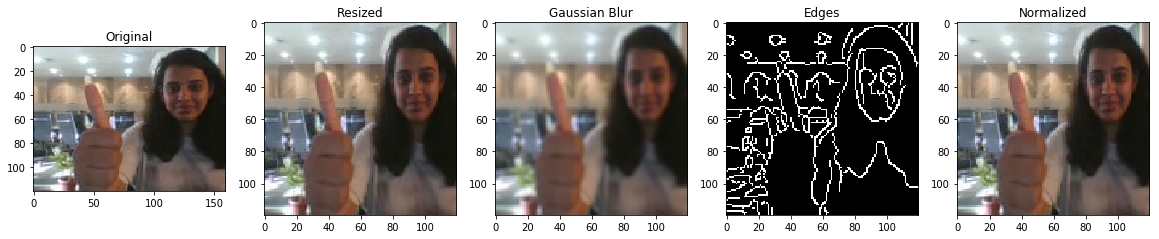

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


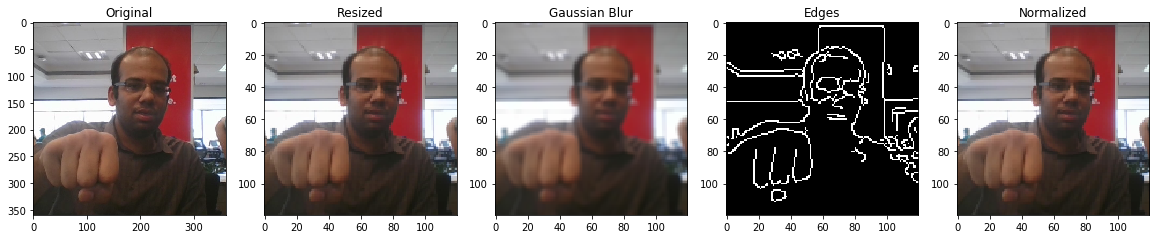

In [12]:
# View the images with their augmented outputs
print('\033[1m' + 'Image for Swipe Left:' + '\033[0m')
imageview(class_0_120, './Project_data/train')
imageview(class_0_360, './Project_data/train')
print('\033[1m' + 'Image for Swipe Right:' + '\033[0m')
imageview(class_1_120, './Project_data/train')
imageview(class_1_360, './Project_data/train')
print('\033[1m' + 'Image for Stop:' + '\033[0m')
imageview(class_2_120, './Project_data/train')
imageview(class_2_360, './Project_data/train')
print('\033[1m' + 'Image for Volume Down:' + '\033[0m')
imageview(class_3_120, './Project_data/train')
imageview(class_3_360, './Project_data/train')
print('\033[1m' + 'Image for Volume Up:' + '\033[0m')
imageview(class_4_120, './Project_data/train')
imageview(class_4_360, './Project_data/train')

**Observations**
- Cropping is not recommended as one can see above that some images are full is shape i.e. useful information can be found in both left and right and top and bottom sides
- Images can be Normalized. Also it looks like all the RGB channels can be normalized in the same way (i.e. divide by 255). There is no need to use different normalization for each channels (This proved right, as we were able to get real good model performance later in the code)
- Gaussian Blur can be used for Augmentation
- Edge detection images are not needed

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
# The generator function
def generator(source_path, folder_list, batch_size, num_frames, frame_height, frame_width, augment):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Based on the number of frames, some frames can be skipped in between. Use linspace function to do that
    img_idx = np.round(np.linspace(5, 25, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))           
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    # Add augmentation (Gaussian Noise Images)
                    if (augment == True):                
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)

                        batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image
                  
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if(augment == True):
                # Add blurred images to the data
                batch_data = np.concatenate([batch_data, batch_data_blur])
                batch_labels = np.concatenate([batch_labels, batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining_data = len(t) % batch_size
        if(remaining_data != 0):
            
            batch_data = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_data,5)) # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))           

            for folder in range(remaining_data): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    # Add augmentation (Gaussian Noise Images)
                    if(augment == True):
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)

                        batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            if(augment == True):
                # Add blurred images to the data
                batch_data = np.concatenate([batch_data, batch_data_blur])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            yield batch_data, batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### Test the Generator Function

In [14]:
# Test the Generator function on training data set
# There are 663 training data points
# So for a batch size of 50, we will have 13 batches of 50 data points and 1 batch of 13 data points

num_frames = 10 
frame_height = 120
frame_width = 120
augment = False

train_generator = generator(train_path, train_doc, batch_size, num_frames, frame_height, frame_width, augment)

for i in range(int(len(train_doc)//batch_size + 1)):
    batch_data_temp, batch_label_temp = next(train_generator)
    print('Shape of each batch: ',batch_data_temp.shape)
    print('Shape of each batch label: ',batch_label_temp.shape)      

Source path =  ./Project_data/train ; batch size = 50
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 10, 120, 120, 3)
Shape of each batch la

In [10]:
# Test the Generator function on validation data set

num_frames = 16
frame_height = 120
frame_width = 120
augment = False

val_generator = generator(val_path, val_doc, batch_size, num_frames, frame_height, frame_width, augment)

if (len(val_doc)%batch_size) == 0:
    for i in range(int(len(val_doc)/batch_size)):
        batch_data_temp, batch_label_temp = next(val_generator)
        print('Shape of each batch: ',batch_data_temp.shape)
        print('Shape of each batch label: ',batch_label_temp.shape)        
else:
    for i in range(int(len(val_doc)//batch_size + 1)):
        batch_data_temp, batch_label_temp = next(val_generator)
        print('Shape of each batch: ',batch_data_temp.shape)
        print('Shape of each batch label: ',batch_label_temp.shape)  

Source path =  ./Project_data/val ; batch size = 50
Shape of each batch:  (50, 16, 120, 120, 3)
Shape of each batch label:  (50, 5)
Shape of each batch:  (50, 16, 120, 120, 3)
Shape of each batch label:  (50, 5)


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Custom functions

Let us write some custom functions first which need to be repeatedly called
1. **generator()** function which is already written above
2. **trainer()** function to fit and train the model and calculate its accuracy and loss
3. **modelplot()** to plot the model accuracy and losses

In [82]:
# Function to fit and train the Model
def trainer(model, model_name, num_epochs, size_batch, num_frames, frame_height, frame_width, augment):

    # Model with the training data
    train_gen = generator(train_path, train_doc, size_batch, num_frames, frame_height, frame_width, augment)
    # Calculate steps per epoch
    if (len(train_doc)%size_batch) == 0:
        train_steps_per_epoch = int(len(train_doc)/size_batch)
    else:
        train_steps_per_epoch = (len(train_doc)//size_batch) + 1

    # Model with validation data (Augmentation is not applied on the validation data set)
    val_gen = generator(val_path, val_doc, size_batch, num_frames, frame_height, frame_width, augment = False)
    # Calculate steps per epoch
    if (len(val_doc)%size_batch) == 0:
        val_steps_per_epoch = int(len(val_doc)/size_batch)
    else:
        val_steps_per_epoch = (len(val_doc)//size_batch) + 1

    # Callback function to save models   
    curr_dt_time = datetime.datetime.now() # Current date and time to store the models with timestamp
    mod_name = model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(mod_name):
        os.mkdir(mod_name)        
    filepath = mod_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)        
        
    # Callback function to reduce learning rate upon reaching a plateau
    LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 4, verbose = 1) # write the REducelronplateau code here
    
    # Early Stop callback function
    earlystop = EarlyStopping(monitor = "val_loss", mode='min', patience = 10, verbose = 1)
    
    # List of all callback functions
    callbacks_list = [checkpoint, LR, earlystop]

    # Fit the model
    history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch, epochs = num_epochs, verbose = 1,
                                      callbacks = callbacks_list, workers = 1, initial_epoch = 0, class_weight = None,
                                      validation_data = val_gen, validation_steps = val_steps_per_epoch)                                        
  
    return history_obj

In [18]:
# Custom function for plotting accuracies and losses of the model
def modelplot(history):
    
    fig = plt.figure(figsize = (16, 5))
    
    # Plot the loss
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train_loss','val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plot the accuracy
    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.legend(['train_categorical_accuracy','val_categorical_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.show()

### Sample Model
- Write a sample model to decide the batch size, image size and number of frames

In [19]:
# Test Conv3D Model for test run
def model_Conv3D_Test(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

### Deciding the batch size, image size and number of frames

Time taken and the memory needed to train the model is greatly affected by the batch size, image size and number of frames. Let us chose some values judiciously
- Experiment with different batch size till we hit the OOM error of GPU
- Let us try three image sizes - 100x100, 120x120 and 160x160
- Choose appropriate number of frames

#### Choosing Batch Size

- With augmentation ON, we hit the OOM error when batch size is greater than 50. **So, we choose the batch size as 50**

#### Choose the image size

In [20]:
# Model with image size 100x100

num_frames = 30
frame_height = 100
frame_width = 100
size_batch = 50
num_epochs = 2
augment = False

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam() 
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 50, 50, 32)    128       
__________

In [21]:
# Model with image size 120x120
 
num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 2
augment = False

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam() 
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_9 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 60, 60, 32)    128       
__________

In [22]:
# Model with image size 160x160

num_frames = 30
frame_height = 160
frame_width = 160
size_batch = 30 # Batch size should be less here as image size is more to avoid OOM error (happened at batch size > 30).
num_epochs = 2
augment = False

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam() 
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_15 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_16 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 80, 80, 32)    128       
__________

- As one can see **`120x120` size** seems best as it takes lesser time and at the same time gives better accuracy. 
- It is a good balance between time and accuracy. 
- It also helps us to choose higher batch size

#### Choose number of frames

We went ahead with one thought: Even one single image is capable enough to determine whether it is a Thumbs Up, Thumbs Down or Stop. For identifying Left and Right Swipes, we need at the most two images. This means we can manage with a smaller number of frames instead of all 30. So, **we chose 10 as the number of frames** (This analysis of ours proved right as we later on when we check the accuracy of the models). This also helps us to tackle overfitting.

As these parameters are decided let us start building the model and decide on other parameters such as filter size, layers etc

### Model 1 - Conv3D model with filter size (3,3,3)

- We will start with a smaller number of epochs (20) in the beginning till we get all the parameters we need. Then we will switch to higher number of epochs (100)
- First let us choose the right kernel size.
- We will try with kernel sizes (3,3,3) (in Model 1) and (2,2,2) (in Model 2) and choose the best one

In [23]:
# Model 1 - Conv3D Model with filter size (3,3,3)
def model_Conv3D_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_26 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_27 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 60, 60, 32)     128       
__________

14/14 [==============================] - 30s 2s/step - loss: 0.1173 - categorical_accuracy: 0.9771 - val_loss: 0.8668 - val_categorical_accuracy: 0.7000

Epoch 00016: saving model to Conv3D_1_2020-12-2512_26_59.404903/model-00016-0.12008-0.97587-0.86676-0.70000.h5
Epoch 17/20
14/14 [==============================] - 29s 2s/step - loss: 0.1273 - categorical_accuracy: 0.9756 - val_loss: 0.7900 - val_categorical_accuracy: 0.7200

Epoch 00017: saving model to Conv3D_1_2020-12-2512_26_59.404903/model-00017-0.12448-0.97436-0.79000-0.72000.h5
Epoch 18/20
14/14 [==============================] - 29s 2s/step - loss: 0.1082 - categorical_accuracy: 0.9799 - val_loss: 0.7126 - val_categorical_accuracy: 0.7300

Epoch 00018: saving model to Conv3D_1_2020-12-2512_26_59.404903/model-00018-0.10898-0.97888-0.71258-0.73000.h5

Epoch 00018: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 19/20
14/14 [==============================] - 29s 2s/step - loss: 0.1064 - categorical_accura

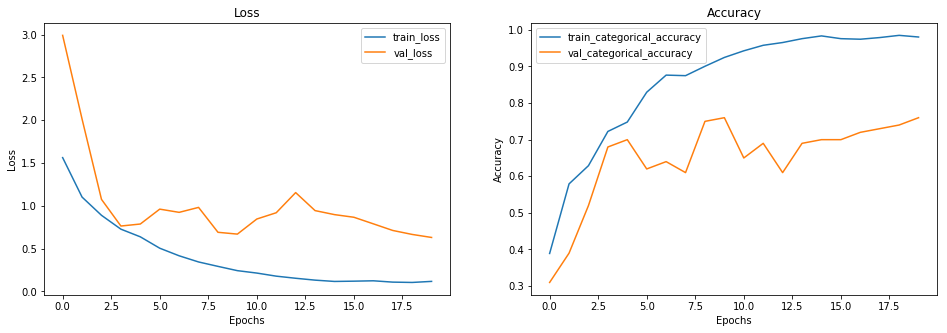

In [25]:
# Model 1 - Conv3D Model with filter size (3,3,3)

frame_height = 120
frame_width = 120
num_frames = 16
size_batch = 50
num_epochs = 20
augment = False

model = model_Conv3D_1(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- As one can see, **Model 1 is clearly overfitting**
- Let us see if the kernel size (2,2,2) solves the overfitting problem

### Model 2 - Conv3D model with filter size (2,2,2)

In [26]:
# Model 2 - Conv3D Model with filter size (2,2,2)
def model_Conv3D_2(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_37 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_38 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 60, 60, 32)     128       
__________

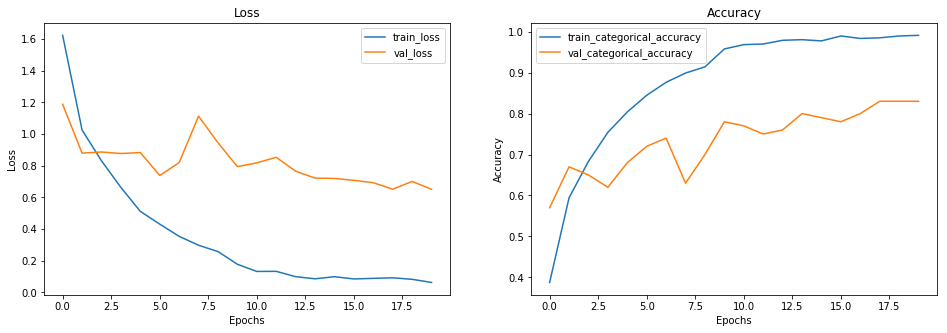

In [28]:
# Model 2 - Conv3D Model with filter size (2,2,2)

num_frames = 16
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 20
augment = False

model = model_Conv3D_2(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- **Model 2 is also overfitting** but is better than Model 1
- As one can see, **(2,2,2) kernel size** is better suited than (3,3,3)
- It also means lesser parameters to train and hence a bit faster

### Model 3 - Conv3D model with dropouts at each convolution layer

- Let us add DropOuts at the end of each convolution layer and see how it affects the model performance

In [29]:
# Model 3 - Conv3D model with dropouts at each convolution layer
def model_Conv3D_3(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
        
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_48 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_49 (Activation)   (None, 8, 60, 60, 32)     0         
__________

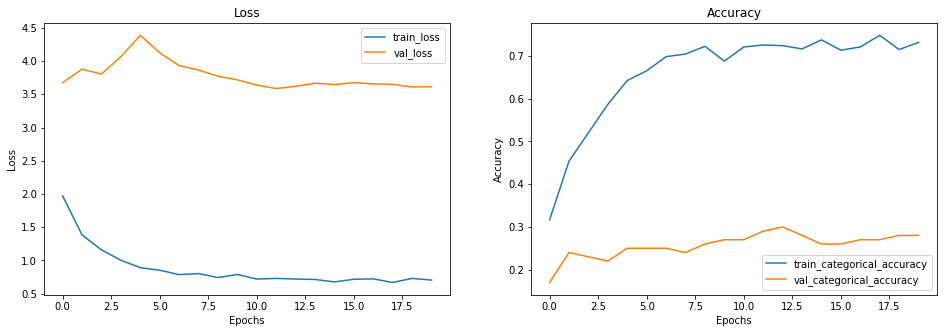

In [31]:
# Model 3 - Conv3D model with dropouts at each convolution layer

num_frames = 16
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 20
augment = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam() 
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- As one can see, adding DropOut at the end of each convolution layer is a very bad idea as the model severely overfits.
- Hence we **remove those Dropouts**

### Model 4 - Conv3D model with 128 dense neurons

- Let us now fix the number of neurons in the dense layer
- Let us select between 128 and 64 neurons in each dense layer

In [32]:
# Model 4 - Conv3D model with 128 dense neurons
def model_Conv3D_4(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_73 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_280 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_107 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_74 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_281 (Activation)  (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 8, 60, 60, 32)     128       
__________

14/14 [==============================] - 30s 2s/step - loss: 0.0203 - categorical_accuracy: 1.0000 - val_loss: 0.7103 - val_categorical_accuracy: 0.8400

Epoch 00016: saving model to Conv3D_4_2020-12-2516_33_23.905825/model-00016-0.01831-1.00000-0.71030-0.84000.h5
Epoch 17/20
14/14 [==============================] - 30s 2s/step - loss: 0.0216 - categorical_accuracy: 0.9971 - val_loss: 0.6991 - val_categorical_accuracy: 0.8500

Epoch 00017: saving model to Conv3D_4_2020-12-2516_33_23.905825/model-00017-0.02218-0.99698-0.69913-0.85000.h5
Epoch 00017: early stopping


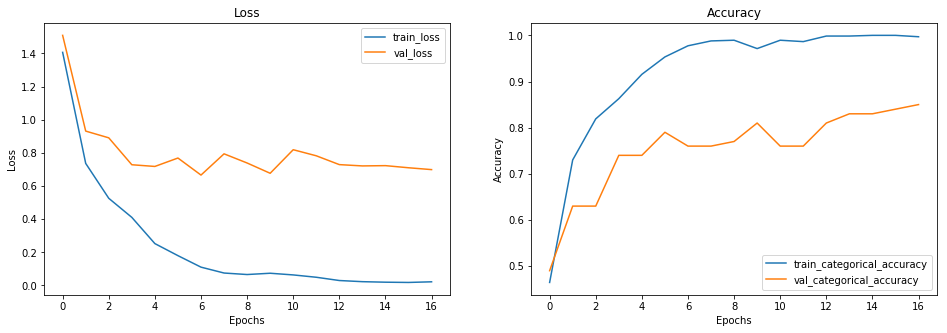

In [91]:
# Model 4 - Conv3D model with 128 dense neurons

num_frames = 16
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 20
augment = False

model = model_Conv3D_4(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_4', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- **Overfitting** issue is still there, let us see how model with 64 neurons in dense layers performs

### Model 5 - Conv3D model with 64 dense neurons

In [35]:
# Model 5 - Conv3D model with 64 dense neurons
def model_Conv3D_5(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_66 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_67 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 8, 60, 60, 32)     128       
__________

14/14 [==============================] - 30s 2s/step - loss: 0.0621 - categorical_accuracy: 0.9986 - val_loss: 0.6387 - val_categorical_accuracy: 0.8000

Epoch 00016: saving model to Conv3D_5_2020-12-2512_26_59.404903/model-00016-0.06202-0.99849-0.63869-0.80000.h5
Epoch 17/20
14/14 [==============================] - 30s 2s/step - loss: 0.0654 - categorical_accuracy: 0.9986 - val_loss: 0.6135 - val_categorical_accuracy: 0.8200

Epoch 00017: saving model to Conv3D_5_2020-12-2512_26_59.404903/model-00017-0.06412-0.99849-0.61346-0.82000.h5
Epoch 18/20
14/14 [==============================] - 30s 2s/step - loss: 0.0624 - categorical_accuracy: 1.0000 - val_loss: 0.5981 - val_categorical_accuracy: 0.8100

Epoch 00018: saving model to Conv3D_5_2020-12-2512_26_59.404903/model-00018-0.05773-1.00000-0.59813-0.81000.h5
Epoch 19/20
14/14 [==============================] - 30s 2s/step - loss: 0.0585 - categorical_accuracy: 0.9986 - val_loss: 0.5869 - val_categorical_accuracy: 0.8300

Epoch 00019: sa

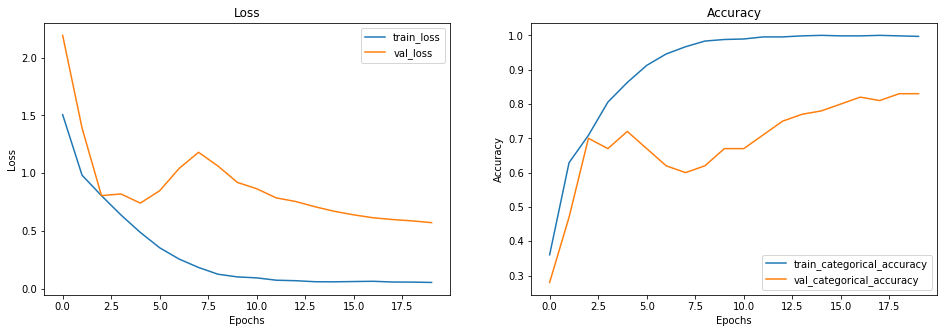

In [36]:
# Model 5 - Conv3D model with 64 dense neurons

num_frames = 16
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 20
augment = False

model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam() 
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_5', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- Overfitting issue is still there in both models with 128 neurons and 64 neurons in dense layers. So, we decided to go with **128 neurons in the dense layers**

### Model 6 - Conv3D model with SGD optimizer

- Let us choose between Adam and SGD Optimizers
- Previous models have already been run with Adam Optimizer, so we try with SGD here

In [37]:
# Model 6 - Conv3D model with SGD optimizer
def model_Conv3D_6(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_73 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_74 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 8, 60, 60, 32)     128       
__________


Epoch 00016: saving model to Conv3D_6_2020-12-2512_26_59.404903/model-00016-0.12675-0.98643-0.59328-0.82000.h5
Epoch 17/20
14/14 [==============================] - 30s 2s/step - loss: 0.1042 - categorical_accuracy: 0.9847 - val_loss: 0.5963 - val_categorical_accuracy: 0.8100

Epoch 00017: saving model to Conv3D_6_2020-12-2512_26_59.404903/model-00017-0.10430-0.98793-0.59626-0.81000.h5
Epoch 18/20
14/14 [==============================] - 30s 2s/step - loss: 0.0993 - categorical_accuracy: 0.9890 - val_loss: 0.5704 - val_categorical_accuracy: 0.8100

Epoch 00018: saving model to Conv3D_6_2020-12-2512_26_59.404903/model-00018-0.09770-0.99246-0.57036-0.81000.h5
Epoch 19/20
14/14 [==============================] - 30s 2s/step - loss: 0.0919 - categorical_accuracy: 0.9943 - val_loss: 0.6170 - val_categorical_accuracy: 0.8000

Epoch 00019: saving model to Conv3D_6_2020-12-2512_26_59.404903/model-00019-0.09226-0.99397-0.61698-0.80000.h5
Epoch 20/20
14/14 [==============================] - 29s 

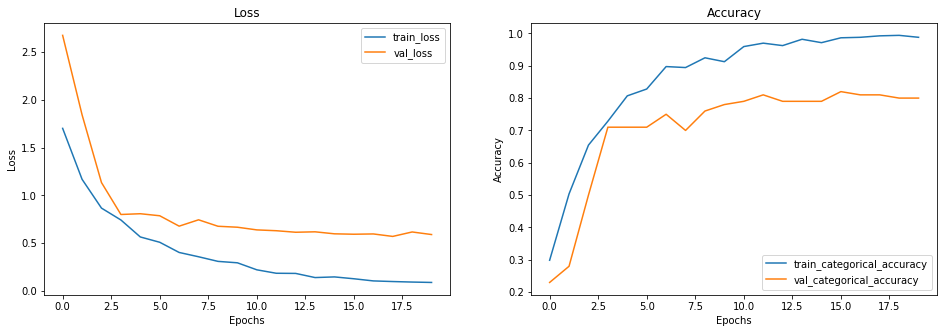

In [38]:
# Model 6 - Conv3D model with SGD optimizer

num_frames = 16
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 20
augment = False

model = model_Conv3D_6(num_frames, frame_height, frame_width)
optimiser = optimizers.SGD()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_6', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- Comparing both, we choose **Adam Optimizer** over SGD Optimizer

### Model 7 - Conv3D Modifed model without augmentation

- From the first six models, we have now almost reached our final model with best parameters
- From here onwards, we will try 100 epochs (and also allow the Early Stopping to kick in if model performance starts to drop) so that model gets more chance to get trained

In [78]:
# Model 7 - Conv3D model without augmentation
def model_Conv3D_7(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16,(2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 10, 120, 120, 16)  400       
_________________________________________________________________
activation_267 (Activation)  (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 5, 60, 60, 32)     4128      
_________________________________________________________________
activation_268 (Activation)  (None, 5, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 5, 60, 60, 32)     128       
__________


Epoch 00015: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00015-0.45626-0.81900-0.77335-0.73000.h5
Epoch 16/100
14/14 [==============================] - 20s 1s/step - loss: 0.3806 - categorical_accuracy: 0.8609 - val_loss: 0.6850 - val_categorical_accuracy: 0.7700

Epoch 00016: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00016-0.39014-0.85370-0.68496-0.77000.h5

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 17/100
14/14 [==============================] - 16s 1s/step - loss: 0.3362 - categorical_accuracy: 0.8743 - val_loss: 0.6301 - val_categorical_accuracy: 0.8300

Epoch 00017: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00017-0.34320-0.87179-0.63012-0.83000.h5
Epoch 18/100
14/14 [==============================] - 20s 1s/step - loss: 0.3397 - categorical_accuracy: 0.8772 - val_loss: 0.5854 - val_categorical_accuracy: 0.8300

Epoch 00018: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00018-0.34639


Epoch 00044: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00044-0.16789-0.93967-0.38034-0.87000.h5
Epoch 45/100
14/14 [==============================] - 19s 1s/step - loss: 0.1609 - categorical_accuracy: 0.9470 - val_loss: 0.3757 - val_categorical_accuracy: 0.8800

Epoch 00045: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00045-0.14783-0.95626-0.37573-0.88000.h5
Epoch 46/100
14/14 [==============================] - 20s 1s/step - loss: 0.1600 - categorical_accuracy: 0.9403 - val_loss: 0.3723 - val_categorical_accuracy: 0.8800

Epoch 00046: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00046-0.16128-0.94118-0.37229-0.88000.h5
Epoch 47/100
14/14 [==============================] - 19s 1s/step - loss: 0.1652 - categorical_accuracy: 0.9512 - val_loss: 0.3732 - val_categorical_accuracy: 0.8800

Epoch 00047: saving model to Conv3D_7_2020-12-2515_45_22.676745/model-00047-0.16682-0.94872-0.37315-0.88000.h5
Epoch 48/100
14/14 [==============================] - 

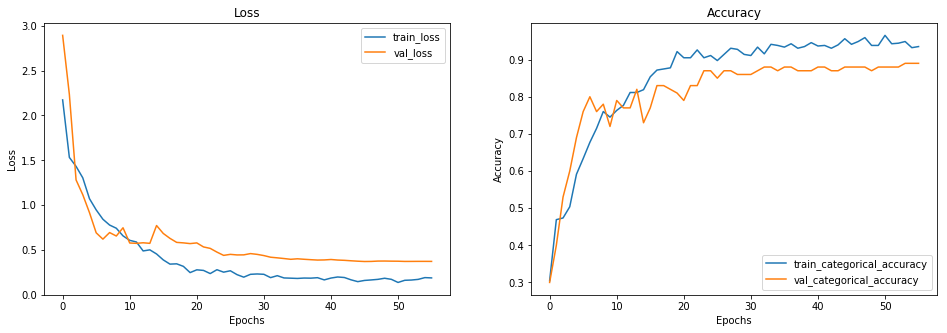

In [83]:
# Model 7 - Conv3D model without augmentation

num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 50
# From here onwards, we will try 100 epochs (and also allow the Early Stopping to kick in if model performance 
# starts to drop) so that model gets more chance to get trained
num_epochs = 100
augment = False

model = model_Conv3D_7(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_7', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- Model has really performed well with **93.8% training accuracy and 89% validation accuracy**
- Let us if augmentation improves the model performance or not

### Model 8 - Conv3D Modifed model with augmentation

In [41]:
# Model 8 - Conv3D model with augmentation (same model as Model 7 but with additional augmentation data)
def model_Conv3D_8(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16,(2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 10, 120, 120, 16)  400       
_________________________________________________________________
activation_87 (Activation)   (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 5, 60, 60, 32)     4128      
_________________________________________________________________
activation_88 (Activation)   (None, 5, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 5, 60, 60, 32)     128       
__________

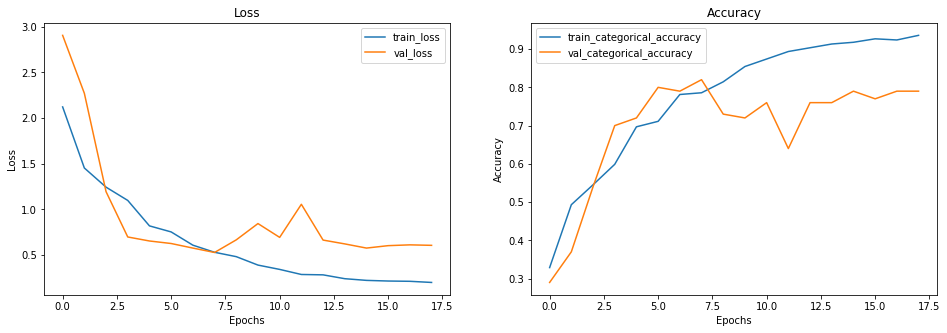

In [42]:
# Model 8 - Conv3D model with augmentation (same model as Model 7 but with additional augmentation data)

num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 100
augment = True

model = model_Conv3D_8(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_8', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
modelplot(model_history)

- Augmentation has caused the performance to go down and the model also has started to overfit.
- **Hence Augmentation will not be used for model training**
- This means Model 7 is the winner so far from Conv3D category
- Let us pit it against the LSTM and GRU models and see which one wins the battle

### Model 9 - CNN LSTM Model

- Now let us create a LSTM model
- Note that, so far for all the Conv3D models, we have used the Relu as activation function
- But for LSTM models, we will use tanh as the activation function. Reason is well documented in this stackoverflow thread: https://stats.stackexchange.com/questions/444923/activation-function-between-lstm-layers
- It says "Given that ReLUs can have quite large outputs, they have traditionally been regarded as inappropriate for use with LSTMs"

In [43]:
# Model 9 - CNN LSTM Model
def model_LSTM_9(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))    
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
 
    model.add(LSTM(units=50, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
   
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [44]:
# Model 9 - CNN LSTM Model

num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 100
augment = False

model = model_LSTM_9(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 120, 120, 16)  208       
_________________________________________________________________
activation_94 (Activation)   (None, 10, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 60, 60, 32)    2080      
_________________________________________________________________
activation_95 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 60, 60, 32)    128       
__________

In [45]:
model_history = trainer(model, 'LSTM_9', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

14
2
Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - 25s 2s/step - loss: 1.5507 - categorical_accuracy: 0.2828 - val_loss: 1.2759 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to LSTM_9_2020-12-2512_26_59.404903/model-00001-1.55873-0.27753-1.27590-0.54000.h5
Epoch 2/100
14/14 [==============================] - 12s 849ms/step - loss: 1.3657 - categorical_accuracy: 0.4043 - val_loss: 1.2164 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to LSTM_9_2020-12-2512_26_59.404903/model-00002-1.36301-0.41327-1.21637-0.52000.h5
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 1.2293 - categorical_accuracy: 0.4663 - val_loss: 1.1030 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to LSTM_9_2020-12-2512_26_59.404903/model-00003-1.23648-0.45852-1.10297-0.55000.h5
Epoch 4/100
14/14 [==============================] - 19s 1s/s

14/14 [==============================] - 19s 1s/step - loss: 0.2458 - categorical_accuracy: 0.9231 - val_loss: 0.5635 - val_categorical_accuracy: 0.8100

Epoch 00030: saving model to LSTM_9_2020-12-2512_26_59.404903/model-00030-0.24919-0.92308-0.56354-0.81000.h5
Epoch 31/100
14/14 [==============================] - 19s 1s/step - loss: 0.2146 - categorical_accuracy: 0.9489 - val_loss: 0.5729 - val_categorical_accuracy: 0.8400

Epoch 00031: saving model to LSTM_9_2020-12-2512_26_59.404903/model-00031-0.21397-0.95023-0.57295-0.84000.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 32/100
14/14 [==============================] - 19s 1s/step - loss: 0.2110 - categorical_accuracy: 0.9426 - val_loss: 0.5800 - val_categorical_accuracy: 0.8400

Epoch 00032: saving model to LSTM_9_2020-12-2512_26_59.404903/model-00032-0.21292-0.93967-0.58003-0.84000.h5
Epoch 33/100
14/14 [==============================] - 19s 1s/step - loss: 0.2289 - categorical_accuracy:

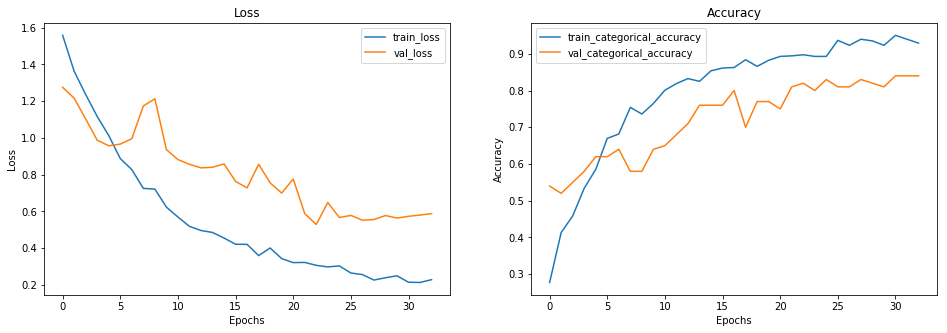

In [46]:
modelplot(model_history)

- The LSTM has performed really well with **92.5% training and 84% validation accuracy**
- Model 7 and Model 9 are neck to neck, but Model 7 has its nose ahead with a slightly better performance

### Model 10 - CNN GRU Model

- Let us try GRU instead of LSTM amd see its performace

In [47]:
# Model 10 - CNN GRU Model
def model_GRU_10(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))    
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(GRU(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
 
    model.add(GRU(units=50, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [86]:
# Model 10 - CNN GRU Model

num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 100
augment = False

model = model_GRU_10(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_35 (TimeDis (None, 10, 120, 120, 16)  208       
_________________________________________________________________
activation_274 (Activation)  (None, 10, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_37 (TimeDis (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 10, 60, 60, 32)    2080      
_________________________________________________________________
activation_275 (Activation)  (None, 10, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 10, 60, 60, 32)    128       
__________

In [89]:
# Run the model and check accuracy
model_history = trainer(model, 'GRU_10', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - 24s 2s/step - loss: 0.3795 - categorical_accuracy: 0.8758 - val_loss: 0.7911 - val_categorical_accuracy: 0.7100

Epoch 00001: saving model to GRU_10_2020-12-2516_16_39.441740/model-00001-0.38484-0.87330-0.79111-0.71000.h5
Epoch 2/100
14/14 [==============================] - 19s 1s/step - loss: 0.4135 - categorical_accuracy: 0.8505 - val_loss: 0.7724 - val_categorical_accuracy: 0.7300

Epoch 00002: saving model to GRU_10_2020-12-2516_16_39.441740/model-00002-0.38115-0.86275-0.77236-0.73000.h5
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 0.3686 - categorical_accuracy: 0.8715 - val_loss: 0.7001 - val_categorical_accuracy: 0.7300

Epoch 00003: saving model to GRU_10_2020-12-2516_16_39.441740/model-00003-0.37561-0.86878-0.70007-0.73000.h5
Epoch 4/100
14/14 [==============================] - 19s 1s/step - lo

14/14 [==============================] - 19s 1s/step - loss: 0.3480 - categorical_accuracy: 0.8663 - val_loss: 0.4636 - val_categorical_accuracy: 0.8300

Epoch 00030: saving model to GRU_10_2020-12-2516_16_39.441740/model-00030-0.33464-0.87934-0.46360-0.83000.h5
Epoch 31/100
14/14 [==============================] - 19s 1s/step - loss: 0.3144 - categorical_accuracy: 0.8806 - val_loss: 0.4626 - val_categorical_accuracy: 0.8300

Epoch 00031: saving model to GRU_10_2020-12-2516_16_39.441740/model-00031-0.30869-0.88235-0.46257-0.83000.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 32/100
14/14 [==============================] - 19s 1s/step - loss: 0.3324 - categorical_accuracy: 0.8930 - val_loss: 0.4644 - val_categorical_accuracy: 0.8300

Epoch 00032: saving model to GRU_10_2020-12-2516_16_39.441740/model-00032-0.33384-0.89140-0.46438-0.83000.h5
Epoch 33/100
14/14 [==============================] - 19s 1s/step - loss: 0.3099 - categorical_accuracy:

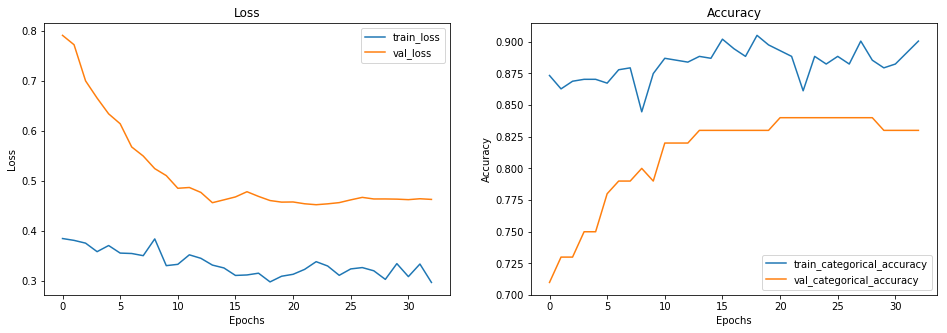

In [90]:
modelplot(model_history)

- Performance of GRU model (Model 10) is comparable to that of the LSTM (Model 9) model but not as good as the Conv3D (Model 7) model

### Model 11 - RESNET50 LSTM Model

- Continuing our experiment, even though we have already met the assignment goal, let us try with Models with Transfer Learning for our learning
- We will try with RESNET50 and VGG16 models
- Note that, even if these models perform better than the previous, they will not be considered as they are not part of the assignment

In [51]:
# Model 11 - RESNET50 LSTM Model
def model_RESNET50_TF_11(num_frames, frame_height, frame_width):

    num_class = 5
    
    def create_base():
        conv_base = ResNet50(weights='imagenet',
                          include_top=False,
                          input_shape=(frame_height, frame_width, 3))
        count=0
        for layer in conv_base.layers:
            count = count+1
        print("num of layers in resnet50 " + str(count))
        # training the model after 140 layers
        split_at = 170
        for layer in conv_base.layers[:split_at]: layer.trainable = False
        for layer in conv_base.layers[split_at:]: layer.trainable = True
        x = GlobalAveragePooling2D()(conv_base.output)
        base_model = Model(conv_base.input, x)
        return base_model
    
    conv_base = create_base()
    
    ip = Input(shape=(num_frames, frame_height, frame_width, 3))
    t_conv = TimeDistributed(conv_base)(ip) 
    drop_l = Dropout(0.5)(t_conv)
    t_lstm1 = LSTM(units=128, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(drop_l)
    
    t_lstm2 = LSTM(units=50, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(t_lstm1)

    f_softmax = Dense(num_class, activation='softmax')(t_lstm2)

    model = Model(ip, f_softmax)
    
    return model

In [57]:
# Model 11 - RESNET50 LSTM transfer Learning Model

num_frames = 10
# RESNET50 has a constraint that the minimum image size is 197x197.
frame_height = 197
frame_width = 197
# Because of larger image size, RESNET50 model causes out of memory errors, so we have compensated it with a smaller
# batch size of 25
size_batch = 25
# Model is slow to run that's why we have reduced the number of epochs to 20 because 100 causes the disk full error
num_epochs = 20
augment = False

model = model_RESNET50_TF_11(num_frames, frame_height, frame_width)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


num of layers in resnet50 174
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 197, 197, 3)   0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 10, 2048)          23587712  
_________________________________________________________________
dropout_42 (Dropout)         (None, 10, 2048)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 128)           1114624   
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 255       
Total params: 24,738,391
Trainable params: 2,205,399
Non-trainable params: 22,532,992
__________________________

In [58]:
# Run the model and check accuracy
model_history = trainer(model, 'RESNET50_11', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

27
4
Source path =  ./Project_data/val ; batch size = 25
Source path =  ./Project_data/train ; batch size = 25
Epoch 1/20
27/27 [==============================] - 75s 3s/step - loss: 1.5230 - categorical_accuracy: 0.3179 - val_loss: 1.6957 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to RESNET50_11_2020-12-2512_26_59.404903/model-00001-1.52583-0.31674-1.69575-0.21000.h5
Epoch 2/20
27/27 [==============================] - 56s 2s/step - loss: 1.1282 - categorical_accuracy: 0.5857 - val_loss: 1.9322 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to RESNET50_11_2020-12-2512_26_59.404903/model-00002-1.13153-0.58522-1.93216-0.23000.h5
Epoch 3/20
27/27 [==============================] - 56s 2s/step - loss: 0.8235 - categorical_accuracy: 0.6979 - val_loss: 2.4979 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to RESNET50_11_2020-12-2512_26_59.404903/model-00003-0.82879-0.69532-2.49792-0.21000.h5
Epoch 4/20
27/27 [==============================] - 

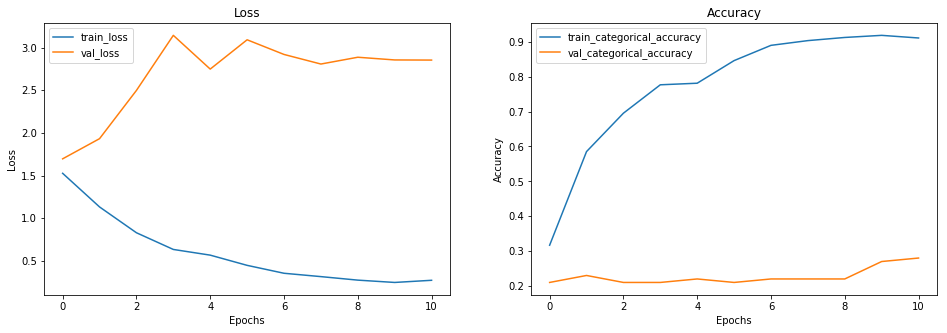

In [59]:
modelplot(model_history)

- The model has badly overfit and will not be pursued further

### Model 12 - VGG16 LSTM Model

- Now let us try the VGG16 model

In [60]:
# Model 12 - VGG16 LSTM Model
def model_VGG16_TF_12(num_frames, frame_height, frame_width):

    num_class = 5
    
    def create_base():
        conv_base = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(frame_height, frame_width, 3))
        count=0
        for layer in conv_base.layers:
            count = count+1
        print("num of layers in resnet50 " + str(count))
        # training the model after 140 layers
        split_at = 17
        for layer in conv_base.layers[:split_at]: layer.trainable = False
        for layer in conv_base.layers[split_at:]: layer.trainable = True
        x = GlobalAveragePooling2D()(conv_base.output)
        base_model = Model(conv_base.input, x)
        return base_model
    
    conv_base = create_base()
    
    ip = Input(shape=(num_frames, frame_height, frame_width, 3))
    t_conv = TimeDistributed(conv_base)(ip) 
    drop_l = Dropout(0.5)(t_conv)
    t_lstm1 = LSTM(units=128, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(drop_l)
    
    t_lstm2 = LSTM(units=50, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(t_lstm1)

    f_softmax = Dense(num_class, activation='softmax')(t_lstm2)

    model = Model(ip, f_softmax)
    
    return model

In [61]:
# Model 12 - VGG16 transfer Learning Model

num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 100
augment = False

model = model_VGG16_TF_12(num_frames, frame_height, frame_width)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

58892288/58889256 [==============================] - 4s 0us/step
num of layers in resnet50 19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 10, 512)           14714688  
_________________________________________________________________
dropout_43 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 128)           328192    
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 255       
Total params: 15,078,935
Trainable params: 2,724

In [62]:
# Run the model and check accuracy
model_history = trainer(model, 'VGG16_12', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

14
2
Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - 48s 3s/step - loss: 1.6222 - categorical_accuracy: 0.2447 - val_loss: 1.5820 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to VGG16_12_2020-12-2512_26_59.404903/model-00001-1.61803-0.25339-1.58203-0.22000.h5
Epoch 2/100
14/14 [==============================] - 22s 2s/step - loss: 1.6114 - categorical_accuracy: 0.2479 - val_loss: 1.5633 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to VGG16_12_2020-12-2512_26_59.404903/model-00002-1.61960-0.23680-1.56332-0.43000.h5
Epoch 3/100
14/14 [==============================] - 21s 2s/step - loss: 1.6011 - categorical_accuracy: 0.2537 - val_loss: 1.5288 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to VGG16_12_2020-12-2512_26_59.404903/model-00003-1.59964-0.25490-1.52877-0.33000.h5
Epoch 4/100
14/14 [==============================] - 22s 2

14/14 [==============================] - 22s 2s/step - loss: 0.1850 - categorical_accuracy: 0.9512 - val_loss: 0.5820 - val_categorical_accuracy: 0.8200

Epoch 00030: saving model to VGG16_12_2020-12-2512_26_59.404903/model-00030-0.18784-0.94872-0.58196-0.82000.h5
Epoch 31/100
14/14 [==============================] - 22s 2s/step - loss: 0.1795 - categorical_accuracy: 0.9426 - val_loss: 0.5654 - val_categorical_accuracy: 0.8100

Epoch 00031: saving model to VGG16_12_2020-12-2512_26_59.404903/model-00031-0.18418-0.93967-0.56542-0.81000.h5
Epoch 32/100
14/14 [==============================] - 22s 2s/step - loss: 0.1914 - categorical_accuracy: 0.9455 - val_loss: 0.5630 - val_categorical_accuracy: 0.8200

Epoch 00032: saving model to VGG16_12_2020-12-2512_26_59.404903/model-00032-0.19734-0.94268-0.56300-0.82000.h5
Epoch 33/100
14/14 [==============================] - 22s 2s/step - loss: 0.1878 - categorical_accuracy: 0.9265 - val_loss: 0.5838 - val_categorical_accuracy: 0.8000

Epoch 00033:

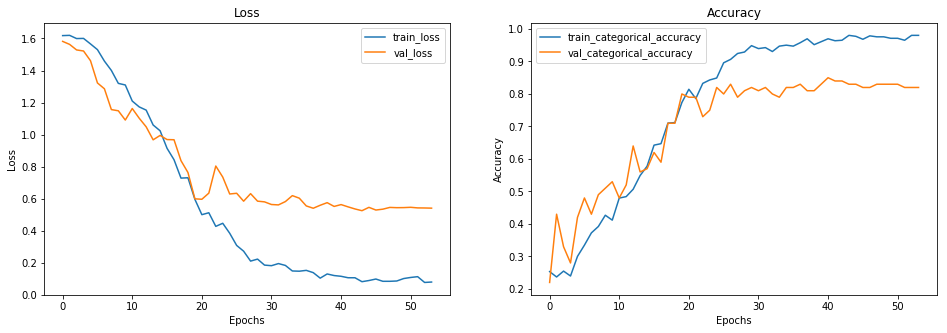

In [63]:
modelplot(model_history)

- Model has performed quite well but then it started to overfit in the later epochs

## Select the best model

- As we have decided earlier, the Model 7 is the winner which is a Conv3D Model
- It has following parameters

In [92]:
# Model 7 Summary
num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 100
augment = False

model = model_Conv3D_7(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_77 (Conv3D)           (None, 10, 120, 120, 16)  400       
_________________________________________________________________
activation_287 (Activation)  (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_112 (Bat (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_77 (MaxPooling (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 5, 60, 60, 32)     4128      
_________________________________________________________________
activation_288 (Activation)  (None, 5, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 5, 60, 60, 32)     128       
__________

# Load the winner model and Test a sample

- Now that we have chosen the winner, let us load it once and use to predict the class of one random image from the validation set just see if the .h5 file is created correctly and also to see if the model works

In [11]:
# Load the winner model i.e. Model 7 (Conv3D) h5 file
model = load_model('Conv3D_7_2020-12-2515_45_22.676745/model-00056-0.18947-0.93514-0.37356-0.89000.h5')

In [14]:
# Test the model using one random image from the validation data set

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 1, num_frames = 10, 
                    frame_height = 120, frame_width = 120, augment = False)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])

Source path =  ./Project_data/val ; batch size = 1
Actual Class of the Image:     2
Predicted Class of the Image:  2


- The model has correctly predicted the class of the random image chosen

- We end the experimentation now